# This a quick way to visualize the latest Hurricane rainfall data from HWRF 

In [44]:
#Import the neccessary modules

import numpy as np
from notebook import *
from ipywidgets import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
from mpl_toolkits.basemap import Basemap, shiftgrid
import glob
import urllib2,urllib
import os
import pandas
%matplotlib notebook

In [45]:
#Lookup the ftp server for the latest folder
path0='ftp://ftp.ncep.noaa.gov/pub/data/nccf/com/hur/prod/'
response=urllib2.urlopen(path0)
ls=response.readlines()
lp=[elem.strip() for elem in ls]


In [46]:
paths=[lp[i].split()[-1] for i in range(np.size(lp))]
paths

['hur.2016070618',
 'hur.2016070700',
 'hwrf.2016070618',
 'hwrf.2016070700',
 'inpdata',
 'inphwrf']

In [47]:
#choose the 3th from the end folder (the latest hwrf ) and isolate the name
fpath=lp[-3].split()[-1]
fpath

'hwrf.2016070700'

In [48]:
# parse the folder 
fresponse=urllib2.urlopen(path0+fpath)
fls=fresponse.readlines()
flp=[elem.strip() for elem in fls]


In [49]:
w=['rainfall' in e for e in flp]

indx=[i for i, x in enumerate(w) if x]

indx

[396, 795, 1194]

If it is more than one hur we choose ...

In [50]:
fname=[flp[indx[i]].split()[-1] for i in range(np.size(indx)) ]
fname

['blas03e.2016070700.rainfall.ascii',
 'four04e.2016070700.rainfall.ascii',
 'nepartak02w.2016070700.rainfall.ascii']

In [51]:
# we choose, remember python indeces start from 0
fname=fname[0]
print fname # VERIFY

blas03e.2016070700.rainfall.ascii


In [52]:
#get hur name
hurName=fname.split('.')[0]
date=fname.split('.')[1]
print hurName, date

blas03e 2016070700


In [53]:
# retrieve file
try:
    urllib.urlretrieve(path0+fpath+'/'+fname, filename='tmp/raindata.txt')
except:
    print 'no such file'

In [54]:
#read file
r=pandas.read_csv('tmp/raindata.txt',header=0)

The file has a header and in the end the track of the Hurricane. So we sort things out

We find the number of points included in the track

In [55]:
ntr=r.convert_objects(convert_numeric=True).dropna()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [56]:
ntr

,-152.55 -117.85 8.85 32.00 0.05 695 464
322481,126


Now the values below line (see index on the left) is the track and above is the lat,lon, so

In [57]:
h=r.columns[0].split() # header

In [58]:
ntr.index[0]

322481

In [59]:
tra=r[ntr.index[0]+1:]

In [60]:
tr=[]
for x in tra.values.ravel():
    tr.append(x.split())

In [61]:
track=np.array(tr).astype(float)

In [62]:
dat=r[:ntr.index[0]] 

In [63]:
#s=data[data.columns[0]].apply(lambda x: pandas.Series(x.split(',')))

In [64]:
data=[]
for x in dat.values.ravel():
    data.append(x.split())

In [65]:
d=np.array(data)

In [66]:
lat=d[:-1,0].astype(float)
lon=d[:-1,1].astype(float)
rainf=d[:-1,2].astype(float)

In [67]:
ni,nj=np.int(h[-1]),np.int(h[-2])

Reshape data to the shape given in the header

In [68]:
lat=lat.reshape(ni,nj) # the last 2 values of the header define grid size
lon=lon.reshape(ni,nj)
rainf=rainf.reshape(ni,nj)

In order to make the plot better we can mask the NaN values (in this case -999.)

In [69]:
rain=np.ma.masked_where(rainf == -999., rainf)

In [70]:
#Define a personal cmap
wlevs = [0.,1.,2.,4.,8.,16.,24.,32.] #specify color map to match NOAA's HWRF
mrain=np.max(wlevs)
colors=['greenyellow','lime','darkgreen','y','yellow','orange','yellow','r']
cmap=mpl.colors.ListedColormap(colors)
norm=mpl.colors.BoundaryNorm(wlevs,cmap.N)

cmap.set_over(mpl.colors.colorConverter.to_rgb('purple'))
cmap.set_under(mpl.colors.colorConverter.to_rgb('w'))


plot the figure

In [90]:
# check user for saving file
user=os.environ['USER']

<IPython.core.display.Javascript object>


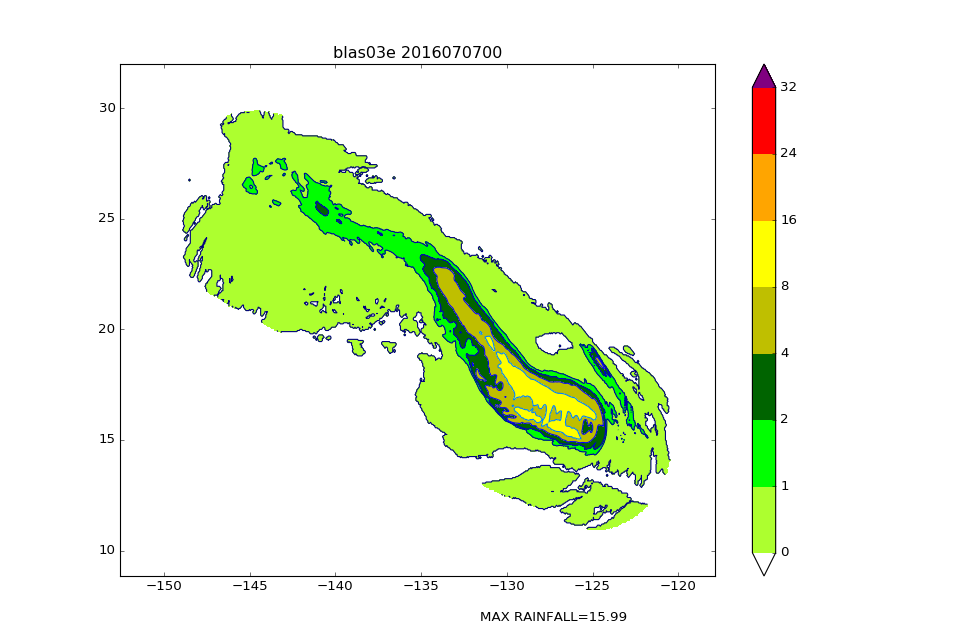

In [92]:

plt.figure(figsize=(12,8))
plt.contourf(lon,lat,rain,wlevs,cmap=cmap,norm=norm, extend='both')
plt.colorbar()
plt.contour(lon,lat,rain,wlevs)
plt.figtext(0.5,0.03,'MAX RAINFALL='+np.str(rain.max()))
#plt.plot(track[:,1],track[:,0],'k') # not the one printed on HWRF site
plt.savefig('tmp/'+user+'_rainf.png',transparent=True)
plt.title(hurName+' '+date)
plt.show()

In [93]:
from osgeo import gdal,gdal_array
import osr

dataTypeformat={1:np.byte,2:np.int32,3:np.int32,4:np.float32,5:np.float32,6:np.byte}
VSType={1:'VS_BOOLEAN',2:'VS_NOMINAL',3:'VS_ORDINAL',4:'VS_SCALAR',5:'VS_DIRECTION',6:'VS_LDD'}

def putmap(filename,var,geo,TYPE,nodata):
     driver=gdal.GetDriverByName('PCRaster')
     varw=var.astype(dataTypeformat[TYPE])
     gtype=gdal_array.NumericTypeCodeToGDALTypeCode(varw.dtype)
     NROWS,NCOLS = var.shape
     VS='PCRASTER_VALUESCALE={}'.format(VSType[TYPE])
     dst_ds=driver.Create(filename,NCOLS,NROWS,1,gtype,[VS])
     proj=osr.SpatialReference()
     proj.ImportFromEPSG(4326)
     dst_ds.SetProjection(proj.ExportToWkt())
     dst_ds.SetGeoTransform(geo)
     dst_ds.GetRasterBand(1).WriteArray(varw)
     dst_ds.GetRasterBand(1).SetNoDataValue(nodata)
     dst_ds.FlushCache()
     dst_ds=None
     return


In [94]:
SAVEPATH='/mnt/pandora/Users_Critech/Pamela/'
#SAVEPATH='tmp/'

In [95]:
TYPE=4     
dd=lon[0,1]-lon[0,0]
print dd
geo=(lon.min(),dd,0,lat.max(),0, -dd)  
nodata=-9999.
putmap(SAVEPATH+'rainfall'+hurName+date+'.tif',np.flipud(rain),geo,TYPE,nodata)


0.05
